# Soft Actor Critic

#### Off Policy with Continuous Action Space

## Environment

In [1]:
import gymnasium as gym
import matplotlib
import matplotlib.pyplot as plt

**Continuous Actions:**  Use a `Box(-1, +1, (2,), dtype=np.float32): (np.array([main, lateral]))` action space with two components: 

1. **Main Engine Throttle (`main`):**  
   1. - **Off:**  If `main < 0`.
   2. - **Throttle Scaling:**  Increases linearly from 50% to 100% as `main` ranges from 0 to 1.
   - **Note:**  The main engine does not operate below 50% power.
 
2. **Lateral Boosters Throttle (`lateral`):**
   1. - **Inactive:**  If `-0.5 < lateral < 0.5`.
   2. - **Left Booster:**  Activates when `lateral < -0.5`, scaling throttle from 50% to 100% as `lateral` decreases from -0.5 to -1.
   3. - **Right Booster:**  Activates when `lateral > 0.5`, scaling throttle from 50% to 100% as `lateral` increases from 0.5 to 1.

In [2]:
# Select Lunar Lander v3 as environment
env = gym.make("LunarLander-v3", continuous=True, render_mode="rgb_array")

# Get the number of state observations
state, info = env.reset()
n_observations = len(state)
print(f"Number of state observations: {n_observations}")

print("""State (Observation Space):
x, y
vel_x, vel_y
angle, angle_vel
left_leg_touching, right_leg_touching
      """)
print("Current state: ", state)

print("""Units of the state are as follows:
      ‘x’: (units), ‘y’: (units), 
      ‘vx’: (units/second), ‘vy’: (units/second), 
      ‘angle’: (radians), ‘angular velocity’: (radians/second)
      """)

Number of state observations: 8
State (Observation Space):
x, y
vel_x, vel_y
angle, angle_vel
left_leg_touching, right_leg_touching
      
Current state:  [ 0.00197306  1.4127278   0.19983152  0.08033907 -0.00227947 -0.0452648
  0.          0.        ]
Units of the state are as follows:
      ‘x’: (units), ‘y’: (units), 
      ‘vx’: (units/second), ‘vy’: (units/second), 
      ‘angle’: (radians), ‘angular velocity’: (radians/second)
      


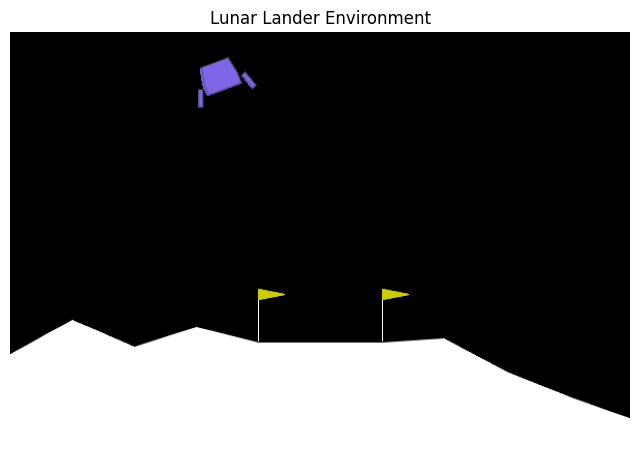

In [3]:
# Reset the environment to get the initial state
state, info = env.reset()

for i in range(40):
    env.step(action=[0, 0])
# Render the environment to get an RGB image
frame = env.render()

# Plot the image
plt.figure(figsize=(8, 6))
plt.imshow(frame)
plt.axis("off")
plt.title("Lunar Lander Environment")
plt.show()

## Plotting Helper

In [4]:
from plotting import MetricsPlotter

In [5]:
plotter = MetricsPlotter()

## ReplayBuffer

In [6]:
import json
import os
from datetime import datetime
from pathlib import Path
from typing import Optional, Tuple, Type

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

In [7]:
from models.models import CriticNetwork, ValueNetwork
from models.SAC import ActorNetwork, SACLosses, compute_actor_loss, compute_critic_loss, compute_value_loss
from models.utils import update_target_network
from ReplayBuffer import ReplayBuffer

## Neural Networks

## Optimization and Target Network Update

In [8]:
def setup_optimizers(
    actor: Type[nn.Module],
    critic_1: Type[nn.Module],
    critic_2: Type[nn.Module],
    value_net: Type[nn.Module],
    learning_rate: float = 3e-4,
) -> Tuple[optim.Optimizer, optim.Optimizer, optim.Optimizer, optim.Optimizer]:
    """
    Sets up optimizers for the actor, critic, and value networks.

    Args:
        actor (ActorNetwork): The actor network.
        critic_1 (CriticNetwork): The first critic network.
        critic_2 (CriticNetwork): The second critic network.
        value_net (ValueNetwork): The value network.
        learning_rate (float): Learning rate for the optimizers.

    Returns:
        Tuple[optim.Optimizer, optim.Optimizer, optim.Optimizer, optim.Optimizer]: Optimizers for actor, critics, and value networks.
    """
    actor_optimizer = optim.Adam(actor.parameters(), lr=learning_rate)
    critic_1_optimizer = optim.Adam(critic_1.parameters(), lr=learning_rate)
    critic_2_optimizer = optim.Adam(critic_2.parameters(), lr=learning_rate)
    value_optimizer = optim.Adam(value_net.parameters(), lr=learning_rate)
    return actor_optimizer, critic_1_optimizer, critic_2_optimizer, value_optimizer

## Saving and Loading Models

In [9]:
def save_models(
    directory: str,
    actor: Type[nn.Module],
    critic_1: Type[nn.Module],
    critic_2: Type[nn.Module],
    value_net: Type[nn.Module],
    target_value_net: Type[nn.Module],
    actor_optimizer: torch.optim.Optimizer,
    critic_1_optimizer: torch.optim.Optimizer,
    critic_2_optimizer: torch.optim.Optimizer,
    value_optimizer: torch.optim.Optimizer,
    episode: int,
    steps_taken: int,
    latest_episode_reward: float,
    model_name: Optional[str] = "sac_checkpoint_best",
) -> None:
    """
    Saves SAC models, optimizers, and metadata to a specified directory.

    Args:
        directory (str): Path to the directory where the models and metadata will be saved.
        actor (Type[nn.Module]): Actor network to save.
        critic_1 (Type[nn.Module]): First critic network to save.
        critic_2 (Type[nn.Module]): Second critic network to save.
        value_net (Type[nn.Module]): Value network to save.
        target_value_net (Type[nn.Module]): Target value network to save.
        actor_optimizer (torch.optim.Optimizer): Optimizer for the actor network.
        critic_1_optimizer (torch.optim.Optimizer): Optimizer for the first critic network.
        critic_2_optimizer (torch.optim.Optimizer): Optimizer for the second critic network.
        value_optimizer (torch.optim.Optimizer): Optimizer for the value network.
        episode (int): Current training episode number.
        steps_taken (int): Total steps taken in the training process.
        latest_episode_reward (float): Reward obtained in the latest episode.
        model_name (Optional[str]): Base name of the saved checkpoint and metadata files. Default is "sac_checkpoint_best".

    Returns:
        None
    """
    # Use pathlib to create the directory
    path = Path(directory)
    path.mkdir(parents=True, exist_ok=True)

    # Save the model checkpoint
    checkpoint_path = path / f"{model_name}.pt"
    torch.save(
        {
            "actor_state_dict": actor.state_dict(),
            "critic_1_state_dict": critic_1.state_dict(),
            "critic_2_state_dict": critic_2.state_dict(),
            "value_net_state_dict": value_net.state_dict(),
            "target_value_net_state_dict": target_value_net.state_dict(),
            "actor_optimizer_state_dict": actor_optimizer.state_dict(),
            "critic_1_optimizer_state_dict": critic_1_optimizer.state_dict(),
            "critic_2_optimizer_state_dict": critic_2_optimizer.state_dict(),
            "value_optimizer_state_dict": value_optimizer.state_dict(),
            "episode": episode,
        },
        checkpoint_path,
    )
    print(f"Models saved to {checkpoint_path}")

    # Save metadata as JSON
    metadata = {
        "episode": episode,
        "steps_taken": steps_taken,
        "latest_episode_reward": latest_episode_reward,
    }
    metadata_path = path / f"{model_name}_metadata.json"
    with metadata_path.open("w") as metadata_file:
        json.dump(metadata, metadata_file, indent=4)
    print(f"Metadata saved to {metadata_path}")


def load_models(
    checkpoint_path: str,
    actor: Type[nn.Module],
    critic_1: Type[nn.Module],
    critic_2: Type[nn.Module],
    value_net: Type[nn.Module],
    target_value_net: Type[nn.Module],
    actor_optimizer: optim.Optimizer,
    critic_1_optimizer: optim.Optimizer,
    critic_2_optimizer: optim.Optimizer,
    value_optimizer: optim.Optimizer,
) -> int:
    """
    Loads SAC models and optimizers from a checkpoint file.

    Args:
        checkpoint_path (str): Full path to the saved checkpoint file.
        actor (Type[nn.Module]): Actor network to load the state into.
        critic_1 (Type[nn.Module]): First critic network to load the state into.
        critic_2 (Type[nn.Module]): Second critic network to load the state into.
        value_net (Type[nn.Module]): Value network to load the state into.
        target_value_net (Type[nn.Module]): Target value network to load the state into.
        actor_optimizer (torch.optim.Optimizer): Optimizer for the actor network to load the state into.
        critic_1_optimizer (torch.optim.Optimizer): Optimizer for the first critic network to load the state into.
        critic_2_optimizer (torch.optim.Optimizer): Optimizer for the second critic network to load the state into.
        value_optimizer (torch.optim.Optimizer): Optimizer for the value network to load the state into.

    Returns:
        int: The episode number extracted from the checkpoint.
    """
    if not os.path.isfile(checkpoint_path):
        raise FileNotFoundError(f"No checkpoint found at {checkpoint_path}")

    checkpoint = torch.load(checkpoint_path)

    actor.load_state_dict(checkpoint["actor_state_dict"])
    critic_1.load_state_dict(checkpoint["critic_1_state_dict"])
    critic_2.load_state_dict(checkpoint["critic_2_state_dict"])
    value_net.load_state_dict(checkpoint["value_net_state_dict"])
    target_value_net.load_state_dict(checkpoint["target_value_net_state_dict"])

    actor_optimizer.load_state_dict(checkpoint["actor_optimizer_state_dict"])
    critic_1_optimizer.load_state_dict(checkpoint["critic_1_optimizer_state_dict"])
    critic_2_optimizer.load_state_dict(checkpoint["critic_2_optimizer_state_dict"])
    value_optimizer.load_state_dict(checkpoint["value_optimizer_state_dict"])

    episode = checkpoint["episode"]
    print(f"Models loaded from {checkpoint_path}, resuming at episode {episode}")
    return episode

## Training

In [10]:
def train_sac(
    env: gym.Env,
    actor: Type[nn.Module],
    critic_1: Type[nn.Module],
    critic_2: Type[nn.Module],
    value_net: Type[nn.Module],
    target_value_net: Type[nn.Module],
    replay_buffer: ReplayBuffer,
    sac_losses: SACLosses,
    actor_optimizer: optim.Optimizer,
    critic_1_optimizer: optim.Optimizer,
    critic_2_optimizer: optim.Optimizer,
    value_optimizer: optim.Optimizer,
    output_dir: str,
    model_name: str,
    num_episodes: int = 1000,
    batch_size: int = 64,
    gamma: float = 0.99,
    tau: float = 0.005,
    evaluate_interval: int = 10,
    reward_window_length: int = 50,
    reward_window_threshold: float = 200.0,
    device: torch.device = torch.device("cpu"),
) -> None:
    """
    Trains the SAC agent.

    Args:
        env (gym.Env): The environment.
        actor, critic_1, critic_2, value_net, target_value_net: Neural networks.
        replay_buffer (ReplayBuffer): Experience replay buffer.
        sac_losses (SACLosses): Loss computation module.
        optimizers: PyTorch optimizers for each network.
        num_episodes (int): Number of training episodes.
        batch_size (int): Batch size for training.
        gamma (float): Discount factor.
        tau (float): Target network update rate.
        evaluate_interval (int): Interval for evaluation and visualization.
    """
    global episode_durations, episode_rewards, policy_losses, value_losses, steps_taken

    # Move models to the selected device
    actor.to(device)
    critic_1.to(device)
    critic_2.to(device)
    value_net.to(device)
    target_value_net.to(device)

    # Create output directory with timestamp
    os.makedirs(output_dir, exist_ok=True)

    best_reward = float("-inf")
    average_window_reward = 0.0

    progress_bar = tqdm(total=num_episodes, desc="Training Progress", position=0, leave=True)

    for episode in range(num_episodes):
        state, _ = env.reset()
        state = torch.tensor(state, dtype=torch.float32, device=device)
        total_reward = 0
        duration = 0

        episode_policy_loss = 0
        episode_value_loss = 0

        while True:
            # Select action using the policy
            with torch.no_grad():
                action, _ = actor.sample_action(state.unsqueeze(0))
                action = action.squeeze(0).cpu().numpy()

            # Interact with the environment
            next_state, reward, truncated, terminated, _ = env.step(action)
            next_state = torch.tensor(next_state, dtype=torch.float32, device=device)
            total_reward += reward
            duration += 1
            steps_taken += 1

            if truncated or terminated:
                done = True
            else:
                done = False

            if duration >= 999:
                done = True

            # Add experience to the replay buffer
            replay_buffer.add(state.cpu().numpy(), action, reward, next_state.cpu().numpy(), done)

            state = next_state

            # Update networks if the buffer is large enough
            if len(replay_buffer) >= batch_size:
                # Sample minibatch
                states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
                states = torch.tensor(states, dtype=torch.float32, device=device)
                actions = torch.tensor(actions, dtype=torch.float32, device=device)
                rewards = torch.tensor(rewards, dtype=torch.float32, device=device).unsqueeze(1)
                next_states = torch.tensor(next_states, dtype=torch.float32, device=device)
                dones = torch.tensor(dones, dtype=torch.float32, device=device).unsqueeze(1)

                # Compute losses
                alpha = sac_losses.get_alpha()
                actor_loss = compute_actor_loss(actor, critic_1, critic_2, states, alpha)
                critic_1_loss = compute_critic_loss(
                    critic_1, target_value_net, states, actions, rewards, next_states, dones, gamma
                )
                critic_2_loss = compute_critic_loss(
                    critic_2, target_value_net, states, actions, rewards, next_states, dones, gamma
                )
                value_loss = compute_value_loss(actor, value_net, critic_1, critic_2, states, alpha)
                entropy_loss = sac_losses.alpha_loss(actor.sample_action(states)[1])

                # Optimize actor
                actor_optimizer.zero_grad()
                actor_loss.backward()
                actor_optimizer.step()

                # Optimize critics
                critic_1_optimizer.zero_grad()
                critic_1_loss.backward()
                critic_1_optimizer.step()

                critic_2_optimizer.zero_grad()
                critic_2_loss.backward()
                critic_2_optimizer.step()

                # Optimize value
                value_optimizer.zero_grad()
                value_loss.backward()
                value_optimizer.step()

                # Optimize alpha if using automatic entropy
                if sac_losses.automatic_entropy:
                    entropy_loss.backward()
                    sac_losses.log_alpha.grad -= entropy_loss.detach()

                # Update target network
                update_target_network(target_value_net, value_net, tau)

                episode_policy_loss += actor_loss.item()
                episode_value_loss += value_loss.item()

                # Update progress bar with current metrics
                progress_bar.set_postfix(
                    {
                        "Episode": episode + 1,
                        "Steps Taken": steps_taken,
                        "Total Reward": total_reward,
                        "Episode Duration": duration,
                        "Avg Policy Loss": np.mean(policy_losses[-10:]) if len(policy_losses) > 10 else 0,
                        "Avg Value Loss": np.mean(value_losses[-10:]) if len(value_losses) > 10 else 0,
                    }
                )
            if done:
                break

        # Track episode metrics
        episode_rewards.append(total_reward)
        episode_durations.append(duration)

        # Track losses
        policy_losses.append(episode_policy_loss / duration)
        value_losses.append(episode_value_loss / duration)

        progress_bar.update(1)

        # if episode > reward_window_length:
        #     average_window_reward = sum(episode_rewards[-reward_window_length:]) / reward_window_length

        #     if average_window_reward > reward_window_threshold:
        #         print("Converged. Ending training")
        #         break

        # Save the best model
        if total_reward > best_reward:
            best_reward = total_reward
            save_models(
                output_dir,
                actor,
                critic_1,
                critic_2,
                value_net,
                target_value_net,
                actor_optimizer,
                critic_1_optimizer,
                critic_2_optimizer,
                value_optimizer,
                episode,
                steps_taken,
                total_reward,
                model_name,
            )
            print(f"New best model saved with reward: {best_reward:.2f}")

        plotter.plot_metrics(episode_durations, episode_rewards, policy_losses, value_losses)

        # # Evaluate periodically
        # if episode % evaluate_interval == 0:
        #     print("Evaluating Policy")
        #     evaluate_sac(env, actor)

    progress_bar.close()

    print("Training complete.")

In [11]:
def evaluate_sac(env: gym.Env, actor: Type[nn.Module], num_episodes: int = 5) -> None:
    """
    Evaluates the SAC agent.

    Args:
        env (gym.Env): The environment.
        actor (ActorNetwork): Trained actor network.
        num_episodes (int): Number of evaluation episodes.
    """
    for episode in range(num_episodes):
        state, _ = env.reset()
        state = torch.tensor(state, dtype=torch.float32)
        total_reward = 0

        while True:
            with torch.no_grad():
                action, _ = actor.sample_action(state.unsqueeze(0))
                action = action.squeeze(0).cpu().numpy()

            next_state, reward, done, _, _ = env.step(action)
            total_reward += reward
            state = torch.tensor(next_state, dtype=torch.float32)

            if done:
                break

        print(f"Evaluation Episode {episode + 1}: Total Reward = {total_reward}")

## Initializations

In [12]:
state_dim = n_observations
action_dim = 2
hidden_dim = 256

# Select device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Replay Buffer

In [13]:
replay_buffer = ReplayBuffer(100000, n_observations, action_dim)

### SAC Losses

In [14]:
sac_losses = SACLosses(device=device)

### Initialize Neural Networks

In [15]:
# Initialize networks
actor = ActorNetwork(state_dim, action_dim, hidden_dim)
critic_1 = CriticNetwork(state_dim, action_dim, hidden_dim)
critic_2 = CriticNetwork(state_dim, action_dim, hidden_dim)
value_net = ValueNetwork(state_dim, hidden_dim)

# Create target network
target_value_net = ValueNetwork(state_dim, hidden_dim)
target_value_net.load_state_dict(value_net.state_dict())

<All keys matched successfully>

### Initialize Optimizers

In [16]:
actor_optimizer, critic_1_optimizer, critic_2_optimizer, value_optimizer = setup_optimizers(
    actor, critic_1, critic_2, value_net, learning_rate=3e-4
)

### Train

In [17]:
N_EPISODES_MAX = 10

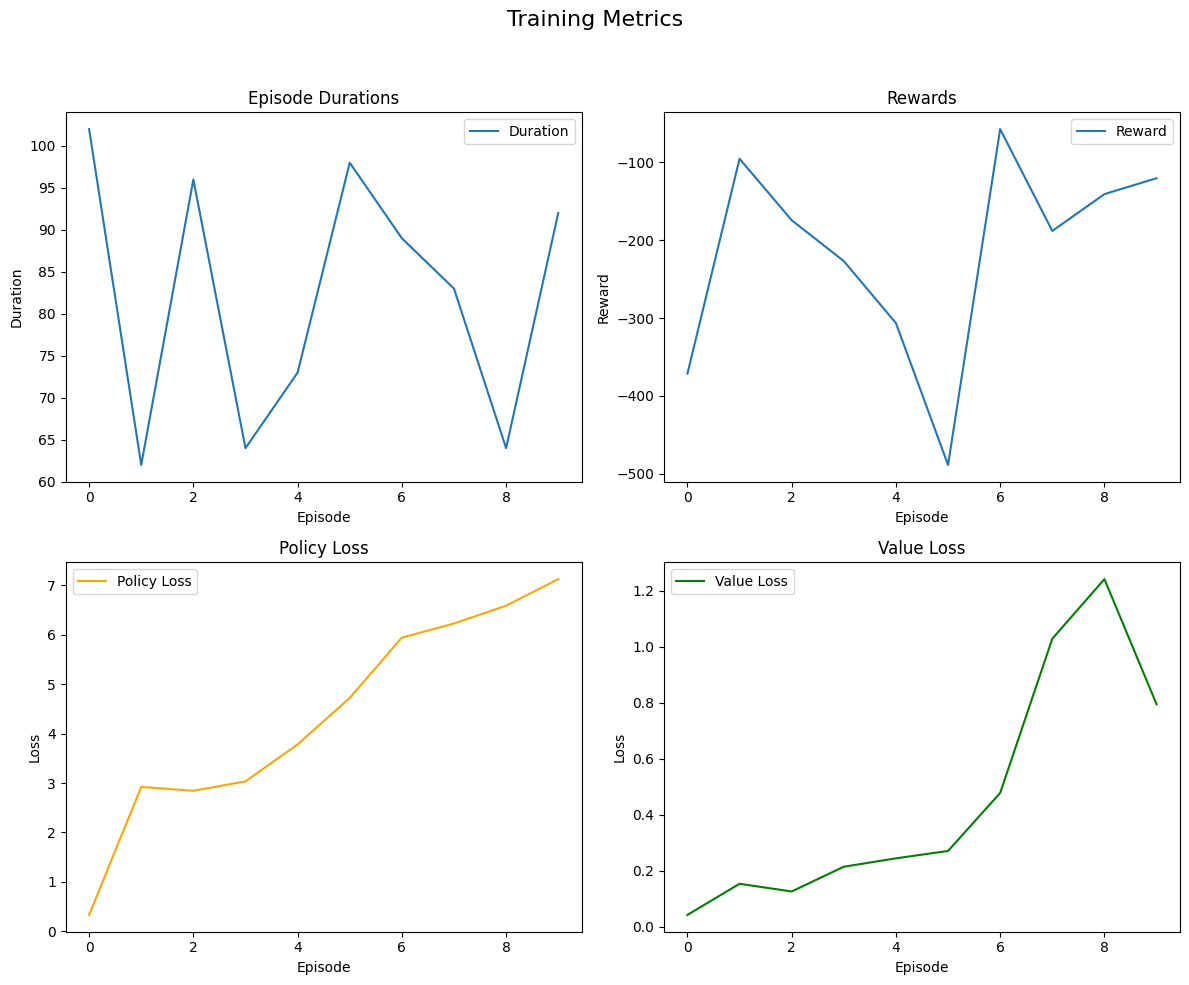

Training Progress: 100%|██████████| 10/10 [00:16<00:00,  1.68s/it, Episode=10, Steps Taken=823, Total Reward=-120, Episode Duration=92, Avg Policy Loss=0, Avg Value Loss=0]

Training complete.


In [18]:
# Global metrics to track performance
episode_durations = []
episode_rewards = []
policy_losses = []
value_losses = []
steps_taken = 0
model_name = "sac_checkpoint_best"

# Timestamp for file saving
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

output_dir = f"pre_trained_models/sac_continuous_lunar_lander_training_{timestamp}"

train_sac(
    env,
    actor,
    critic_1,
    critic_2,
    value_net,
    target_value_net,
    replay_buffer,
    sac_losses,
    actor_optimizer,
    critic_1_optimizer,
    critic_2_optimizer,
    value_optimizer,
    output_dir=output_dir,
    num_episodes=N_EPISODES_MAX,
    batch_size=64,
    gamma=0.99,
    tau=0.005,
    evaluate_interval=10,
    reward_window_threshold=230.0,
    reward_window_length=100,
    model_name=model_name,
    device=device,
)

Metrics figure saved to pre_trained_models/sac_continuous_lunar_lander_training_2024-12-25_11-17-43/soft_actor_critic_continuous_plot


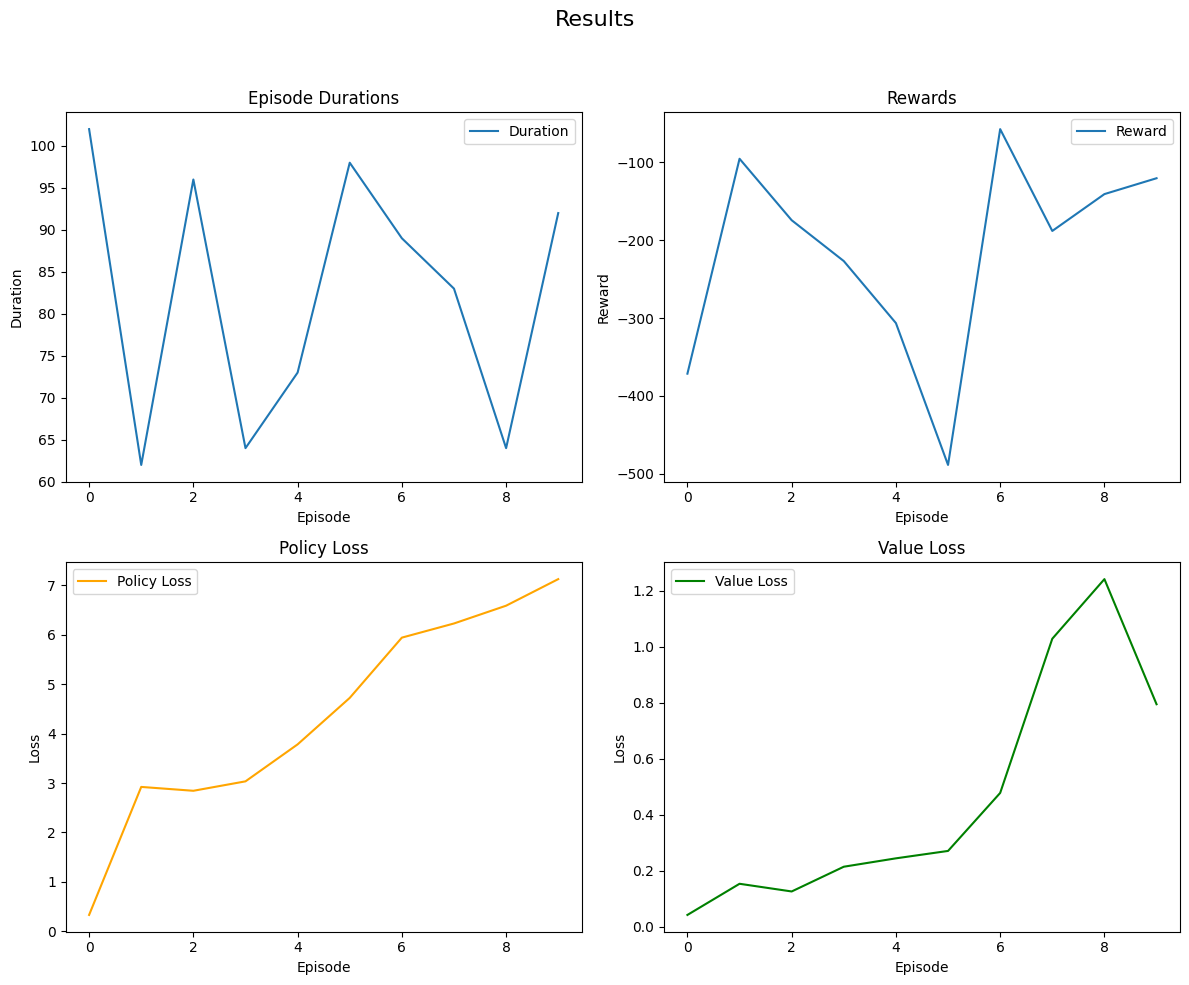

In [19]:
plotter.plot_metrics(
    episode_durations,
    episode_rewards,
    policy_losses,
    value_losses,
    show_result=True,
    save_path=f"{output_dir}/soft_actor_critic_continuous_plot",
)

## Load Saved Checkpoint and Save Policy Network

This policy network can be used to control Lunar Landing in Gymnasium environments

In [20]:
def save_policy_from_checkpoint(
    checkpoint_path: str,
    actor: Type[nn.Module],
    output_path: Optional[str] = None,
) -> None:
    """
    Extracts and saves only the actor (policy network) from a given checkpoint.

    Args:
        checkpoint_path (str): Path to the checkpoint file containing the saved state dictionaries.
        actor (Type[nn.Module]): Actor network instance to load the weights into.
        output_path (Optional[str]): File path to save the extracted policy network as a `.pth` file.
                                     If not provided, the policy is saved in the same directory as the checkpoint
                                     with the name `policy_network.pth`.

    Returns:
        None
    """

    if not os.path.isfile(checkpoint_path):
        raise FileNotFoundError(f"No checkpoint found at {checkpoint_path}")

    # Load the checkpoint
    checkpoint = torch.load(checkpoint_path, weights_only=True)

    # Load actor state dict
    actor.load_state_dict(checkpoint["actor_state_dict"])

    # Derive default output path if not provided
    if output_path is None:
        directory = os.path.dirname(checkpoint_path)
        output_path = os.path.join(directory, "policy_network.pth")

    # Save only the actor's weights
    torch.save(actor.state_dict(), output_path)
    print(f"Policy network saved to {output_path}")

In [21]:
state_dim = n_observations
action_dim = 2
hidden_dim = 256

actor_network = ActorNetwork(state_dim, action_dim, hidden_dim)
checkpoint_path = "output/sac_continuous_lunar_lander_training_2024-12-23_12-52-16/sac_checkpoint_best.pt"

output_dir = Path(output_dir)

# Save the model checkpoint
checkpoint_path = output_dir / f"{model_name}.pt"

save_policy_from_checkpoint(checkpoint_path, actor=actor_network)

Policy network saved to pre_trained_models/sac_continuous_lunar_lander_training_2024-12-25_11-17-43/policy_network.pth
